<h3><strong>Import Libraries</strong></h3>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv("battles.csv", nrows=50000)

In [ ]:
card_map = {
    26000000: "Knight", 26000001: "Archers", 26000002: "Goblins", 26000003: "Giant",
    26000004: "P.E.K.K.A", 26000005: "Minions", 26000006: "Balloon", 26000007: "Witch",
    26000008: "Barbarians", 26000009: "Golem", 26000010: "Skeletons", 26000011: "Valkyrie",
    26000012: "Skeleton Army", 26000013: "Bomber", 26000014: "Musketeer", 26000015: "Baby Dragon",
    26000016: "Prince", 26000017: "Wizard", 26000018: "Mini P.E.K.K.A", 26000019: "Spear Goblins",
    26000020: "Giant Skeleton", 26000021: "Hog Rider", 26000022: "Minion Horde", 26000023: "Ice Wizard",
    26000024: "Royal Giant", 26000025: "Guards", 26000026: "Princess", 26000027: "Dark Prince",
    26000028: "Three Musketeers", 26000029: "Lava Hound", 26000030: "Ice Spirit", 26000031: "Fire Spirits",
    26000032: "Miner", 26000033: "Sparky", 26000034: "Bowler", 26000035: "Lumberjack", 26000036: "Battle Ram",
    26000037: "Inferno Dragon", 26000038: "Ice Golem", 26000039: "Mega Minion", 26000040: "Dart Goblin",
    26000041: "Goblin Gang", 26000042: "Electro Wizard", 26000043: "Elite Barbarians", 26000044: "Hunter",
    26000045: "Executioner", 26000046: "Bandit", 26000047: "Royal Recruits", 26000048: "Night Witch",
    26000049: "Bats", 26000050: "Royal Ghost", 26000051: "Ram Rider", 26000052: "Zappies",
    26000053: "Rascals", 26000054: "Cannon Cart", 26000055: "Mega Knight", 26000056: "Skeleton Barrel",
    26000057: "Flying Machine", 26000058: "Wall Breakers", 26000059: "Royal Hogs", 26000060: "Goblin Giant",
    26000061: "Fisherman", 26000062: "Magic Archer", 26000063: "Electro Dragon", 26000064: "Firecracker",
    26000067: "Elixir Golem", 26000068: "Battle Healer", 26000080: "Skeleton Dragons", 26000083: "Mother Witch",
    26000084: "Electro Spirit", 26000085: "Electro Giant", 27000000: "Cannon", 27000001: "Goblin Hut",
    27000002: "Mortar", 27000003: "Inferno Tower", 27000004: "Bomb Tower", 27000005: "Barbarian Hut",
    27000006: "Tesla", 27000007: "Elixir Collector", 27000008: "X-Bow", 27000009: "Tombstone",
    27000010: "Furnace", 27000012: "Goblin Cage", 28000000: "Fireball", 28000001: "Arrows",
    28000002: "Rage", 28000003: "Rocket", 28000004: "Goblin Barrel", 28000005: "Freeze",
    28000006: "Mirror", 28000007: "Lightning", 28000008: "Zap", 28000009: "Poison",
    28000010: "Graveyard", 28000011: "The Log", 28000012: "Tornado", 28000013: "Clone",
    28000014: "Earthquake", 28000015: "Barbarian Barrel", 28000016: "Heal Spirit",
    28000017: "Giant Snowball", 28000018: "Royal Delivery"
}

# # Bar Plot of Cards used the most
# card_cols = [
#     'winner.card1.id', 'winner.card2.id', 'winner.card3.id', 'winner.card4.id',
#     'winner.card5.id', 'winner.card6.id', 'winner.card7.id', 'winner.card8.id',
#     'loser.card1.id', 'loser.card2.id', 'loser.card3.id', 'loser.card4.id',
#     'loser.card5.id', 'loser.card6.id', 'loser.card7.id', 'loser.card8.id'
# ]

# for col in card_cols:
#     df[col] = df[col].map(card_map)

# # Check first few replacements
# print(df[card_cols].head())

# all_cards = df[card_cols].values.flatten()
# card_counts = pd.Series(all_cards).value_counts()


# plt.figure(figsize=(14, 10))
# sns.barplot(x=card_counts.index, y=card_counts.values)
# plt.title("Frequency of Cards Used in All Matches")
# plt.xlabel("Card ID")
# plt.ylabel("Usage Count")
# plt.xticks(rotation=90)
# plt.show()


In [ ]:
trophy_ranges = [
    (0, 1999),
    (2000, 2999),
    (3000, 3999),
    (4000, 4999),
    (5000, 5999),
    (6000, 6999),
    (7000, 8000),
]
level_cols = [f"winner.card{i}.level" for i in range(1, 9)] + \
             [f"loser.card{i}.level"  for i in range(1, 9)]

def avg_level_for_trophy_range(df, low, high):
    subset = df[
        (df["winner.startingTrophies"].between(low, high)) |
        (df["loser.startingTrophies"].between(low, high))
    ]
    
    # mean of all 16 level columns
    return subset[level_cols].mean().mean()


for low, high in trophy_ranges:
    avg_level = avg_level_for_trophy_range(df, low, high)
    print(f"{low}-{high}: average level = {avg_level:.2f}")




0-1999: average level = nan
2000-2999: average level = 6.67
3000-3999: average level = 7.56
4000-4999: average level = 11.67
5000-5999: average level = 12.67
6000-6999: average level = 12.96
7000-8000: average level = 12.99


In [ ]:
elixir_cost = {
    26000000: 3,  # Knight
    26000001: 3,  # Archers
    26000002: 2,  # Goblins
    26000003: 5,  # Giant
    26000004: 7,  # P.E.K.K.A
    26000005: 3,  # Minions
    26000006: 5,  # Balloon
    26000007: 5,  # Witch
    26000008: 5,  # Barbarians
    26000009: 8,  # Golem
    26000010: 1,  # Skeletons
    26000011: 4,  # Valkyrie
    26000012: 3,  # Skeleton Army
    26000013: 2,  # Bomber
    26000014: 4,  # Musketeer
    26000015: 4,  # Baby Dragon
    26000016: 5,  # Prince
    26000017: 5,  # Wizard
    26000018: 4,  # Mini P.E.K.K.A
    26000019: 2,  # Spear Goblins
    26000020: 6,  # Giant Skeleton
    26000021: 4,  # Hog Rider
    26000022: 5,  # Minion Horde
    26000023: 3,  # Ice Wizard
    26000024: 6,  # Royal Giant
    26000025: 3,  # Guards
    26000026: 3,  # Princess
    26000027: 4,  # Dark Prince
    26000028: 9,  # Three Musketeers
    26000029: 7,  # Lava Hound
    26000030: 1,  # Ice Spirit
    26000031: 2,  # Fire Spirits
    26000032: 3,  # Miner
    26000033: 6,  # Sparky
    26000034: 5,  # Bowler
    26000035: 4,  # Lumberjack
    26000036: 4,  # Battle Ram
    26000037: 4,  # Inferno Dragon
    26000038: 2,  # Ice Golem
    26000039: 3,  # Mega Minion
    26000040: 3,  # Dart Goblin
    26000041: 3,  # Goblin Gang
    26000042: 4,  # Electro Wizard
    26000043: 6,  # Elite Barbarians
    26000044: 4,  # Hunter
    26000045: 5,  # Executioner
    26000046: 3,  # Bandit
    26000047: 7,  # Royal Recruits
    26000048: 4,  # Night Witch
    26000049: 2,  # Bats
    26000050: 3,  # Royal Ghost
    26000051: 5,  # Ram Rider
    26000052: 4,  # Zappies
    26000053: 5,  # Rascals
    26000054: 5,  # Cannon Cart
    26000055: 7,  # Mega Knight
    26000056: 3,  # Skeleton Barrel
    26000057: 4,  # Flying Machine
    26000058: 2,  # Wall Breakers
    26000059: 4,  # Royal Hogs
    26000060: 6,  # Goblin Giant
    26000061: 3,  # Fisherman
    26000062: 4,  # Magic Archer
    26000063: 5,  # Electro Dragon
    26000064: 3,  # Firecracker
    26000067: 3,  # Elixir Golem
    26000068: 4,  # Battle Healer
    26000080: 4,  # Skeleton Dragons
    26000083: 4,  # Mother Witch
    26000084: 1,  # Electro Spirit
    26000085: 8,  # Electro Giant

    # Buildings
    27000000: 3,  # Cannon
    27000001: 5,  # Goblin Hut
    27000002: 4,  # Mortar
    27000003: 5,  # Inferno Tower
    27000004: 4,  # Bomb Tower
    27000005: 7,  # Barbarian Hut
    27000006: 4,  # Tesla
    27000007: 6,  # Elixir Collector
    27000008: 6,  # X-Bow
    27000009: 3,  # Tombstone
    27000010: 4,  # Furnace
    27000012: 4,  # Goblin Cage

    # Spells
    28000000: 4,  # Fireball
    28000001: 3,  # Arrows
    28000002: 2,  # Rage
    28000003: 6,  # Rocket
    28000004: 3,  # Goblin Barrel
    28000005: 4,  # Freeze
    28000006: 1,  # Mirror (variable but cost = last card + 1)
    28000007: 6,  # Lightning
    28000008: 2,  # Zap
    28000009: 4,  # Poison
    28000010: 5,  # Graveyard
    28000011: 2,  # The Log
    28000012: 3,  # Tornado
    28000013: 3,  # Clone
    28000014: 3,  # Earthquake
    28000015: 2,  # Barbarian Barrel
    28000016: 1,  # Heal Spirit
    28000017: 2,  # Giant Snowball
    28000018: 3   # Royal Delivery
}

In [ ]:
#optimizer

X = []
Y = []

my_deck = ["Hog Rider", 
 "Skeletons", 
 "Fireball", 
 "Cannon", 
 "Ice Spirit", 
 "Musketeer", 
 "Ice Golem", 
 "The Log"]
reverse_map = {name.lower(): cid for cid, name in card_map.items()}

my_levels = [13, 13, 13, 13, 13, 13, 13, 13]
my_trophies = 6000

for idx, row in df.iterrows():

    # --- Total Levels ---
    winner_total = sum(row[f"winner.card{i}.level"] for i in range(1,9))
    loser_total  = sum(row[f"loser.card{i}.level"]  for i in range(1,9))

    winner_adv = winner_total - loser_total
    loser_adv  = -winner_adv

    # --- Build features for Winner (A) ---
    A = []
    for i in range(1, 9):
        A += [row[f"winner.card{i}.id"], row[f"winner.card{i}.level"]]
    A += [
        row["winner.troop.count"],
        row["winner.spell.count"],
        row["winner.structure.count"],
        row["winner.elixir.average"],
        row["winner.startingTrophies"],
        row["arena.id"],
        winner_adv
    ]

    # --- Build features for Loser (B) ---
    B = []
    for i in range(1, 9):
        B += [row[f"loser.card{i}.id"], row[f"loser.card{i}.level"]]
    B += [
        row["loser.troop.count"],
        row["loser.spell.count"],
        row["loser.structure.count"],
        row["loser.elixir.average"],
        row["loser.startingTrophies"],
        row["arena.id"],
        loser_adv
    ]

    # -------- TRAINING ROWS ------------
    # Winner (A) vs Loser (B)
    X.append(A + B)
    Y.append(1)

    # Loser (B) vs Winner (A)
    X.append(B + A)
    Y.append(0)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import random

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(Y_test, y_pred))
print(classification_report(Y_test, y_pred))

def deck_features(deck, levels, trophies):
    ids = []

    for c in deck:
        if isinstance(c, str):
            ids.append(reverse_map[c.lower()])
        else:
            ids.append(int(c))

    levels = [min(13, int(l)) for l in levels]
    trophies = float(min(max(trophies, 0), 7500))

    elixir_avg = sum(elixir_cost[i] for i in ids) / 8

    troop_count     = sum(1 for i in ids if 26000000 <= i < 27000000)
    structure_count = sum(1 for i in ids if 27000000 <= i < 28000000)
    spell_count     = sum(1 for i in ids if 28000000 <= i < 29000000)

    arena_id = float(54000000 + int(trophies // 300))

    # Level advantage relative to expected opponent
    opp_avg_level = (
        12.99 if trophies >= 7000 else
        12.96 if trophies >= 6000 else
        12.83 if trophies >= 5000 else
        11.99 if trophies >= 4000 else
        7.73  if trophies >= 3000 else
        6.72  if trophies >= 2000 else
        5.94
    )

    level_adv = sum(levels) - 8 * opp_avg_level

    feat = []
    for i in range(8):
        feat.append(ids[i])
        feat.append(levels[i])

    feat += [
        troop_count,
        spell_count,
        structure_count,
        elixir_avg,
        trophies,
        arena_id,
        level_adv
    ]

    return feat

def predict_matchup(A_deck, A_lvls, A_trophies,
                    B_deck, B_lvls, B_trophies):

    A = deck_features(A_deck, A_lvls, A_trophies)
    B = deck_features(B_deck, B_lvls, B_trophies)

    row1 = A + B  
    p1 = model.predict_proba([row1])[0][1]

    row2 = B + A  
    p2 = model.predict_proba([row2])[0][1]

    # symmetric averaged probability
    return (p1 + (1 - p2)) / 2

def random_opp(df):
    i = random.randint(0, len(df)-1)
    side = "winner" if random.random() < 0.5 else "loser"

    deck = [df.iloc[i][f"{side}.card{j}.id"] for j in range(1, 9)]
    lvls = [df.iloc[i][f"{side}.card{j}.level"] for j in range(1, 9)]
    trophies = df.iloc[i][f"{side}.startingTrophies"]

    return deck, lvls, trophies

def simulate_deck_winrate(deck, lvls, trophies, N=300):
    probs = []

    for _ in range(N):
        opp_deck, opp_lvls, opp_trophies = random_opp(df)
        p = predict_matchup(deck, lvls, trophies,
                            opp_deck, opp_lvls, opp_trophies)
        probs.append(p)

    return sum(probs) / len(probs)

from collections import Counter

def build_meta_decks(df, top_n=300):
    deck_counts = Counter()

    for idx, row in df.iterrows():
        deck = tuple([
            row[f"winner.card{i}.id"] for i in range(1, 9)
        ])
        deck_counts[deck] += 1

    meta = deck_counts.most_common(top_n)
    
    meta_formatted = []
    for deck,_ in meta:
        ids = list(deck)
        lvls = [13]*8  # meta decks are maxed in 2020 dataset
        trophies = 6000
        meta_formatted.append((ids, lvls, trophies))

    return meta_formatted

meta_decks = build_meta_decks(df, top_n=10)
print("Meta decks:", len(meta_decks))

matchup_cache = {}

def cached_predict_matchup(Adeck, Alevels, Atrophies,
                           Bdeck, Blevels, Btrophies):

    key = (tuple(Adeck), tuple(Alevels),
           tuple(Bdeck), tuple(Blevels))

    if key in matchup_cache:
        return matchup_cache[key]

    p = predict_matchup(Adeck, Alevels, Atrophies,
                        Bdeck, Blevels, Btrophies)

    matchup_cache[key] = p
    return p

def winrate_vs_meta(deck, levels, trophies, meta_decks):
    probs = []
    for opp_ids, opp_lvls, opp_trophies in meta_decks:
        p = cached_predict_matchup(
            deck, levels, trophies,
            opp_ids, opp_lvls, opp_trophies
        )
        probs.append(p)
    return sum(probs) / len(probs)


def optimize_deck(deck, levels, trophies, meta_decks, card_pool):
   
    global matchup_cache
    matchup_cache = {}
    base_winrate = winrate_vs_meta(deck, levels, trophies, meta_decks)
    improvements = []

    for slot in range(8):  # each card position
        original_card = deck[slot]

        for new_card in card_pool:
            if new_card == original_card:
                continue
            if new_card in deck:
                continue  # no duplicates

            # try replacing slot i with new_card
            new_deck = deck.copy()
            new_deck[slot] = new_card

            new_winrate = winrate_vs_meta(new_deck, levels, trophies, meta_decks)
            delta = new_winrate - base_winrate

            improvements.append({
                "slot": slot,
                "old_card": original_card,
                "new_card": new_card,
                "old_name": card_map.get(original_card, original_card),
                "new_name": card_map.get(new_card, new_card),
                "base_winrate": base_winrate,
                "new_winrate": new_winrate,
                "delta": delta
            })

    # sort improvements by biggest winrate gain
    improvements.sort(key=lambda x: x["delta"], reverse=True)

    return base_winrate, improvements

card_pool = list(elixir_cost.keys())

my_deck_ids = [reverse_map[c.lower()] for c in my_deck]
matchup_cache = {}
EVAL_TROPHIES = 6000

base, improvements = optimize_deck(
    my_deck_ids,
    my_levels,
    EVAL_TROPHIES,
    meta_decks,
    card_pool
)




winrate = simulate_deck_winrate(my_deck, my_levels, my_trophies, N=300)
print("Estimated Winrate:", winrate)


print("Base winrate:", base)
print("\nTop 10 upgrades:")
for imp in improvements[:10]:
    print(f"Slot {imp['slot']} | {imp['old_name']} → {imp['new_name']} | "
          f"{imp['base_winrate']:.3f} → {imp['new_winrate']:.3f} "
          f"(+{imp['delta']:.3f})")
    
    





Accuracy: 0.743125
              precision    recall  f1-score   support

           0       0.72      0.77      0.74       777
           1       0.77      0.72      0.74       823

    accuracy                           0.74      1600
   macro avg       0.74      0.74      0.74      1600
weighted avg       0.74      0.74      0.74      1600

Meta decks: 10
Estimated Winrate: 0.49983874999999994
Base winrate: 0.3617

Top 10 upgrades:
Slot 4 | Ice Spirit → Electro Wizard | 0.362 → 0.453 (+0.092)
Slot 3 | Cannon → Royal Giant | 0.362 → 0.453 (+0.091)
Slot 4 | Ice Spirit → Elite Barbarians | 0.362 → 0.452 (+0.091)
Slot 3 | Cannon → Three Musketeers | 0.362 → 0.451 (+0.090)
Slot 4 | Ice Spirit → Hunter | 0.362 → 0.451 (+0.090)
Slot 4 | Ice Spirit → Night Witch | 0.362 → 0.451 (+0.090)
Slot 3 | Cannon → Lava Hound | 0.362 → 0.451 (+0.089)
Slot 0 | Hog Rider → P.E.K.K.A | 0.362 → 0.450 (+0.088)
Slot 4 | Ice Spirit → Executioner | 0.362 → 0.450 (+0.088)
Slot 4 | Ice Spirit → Zappies | 0.362 

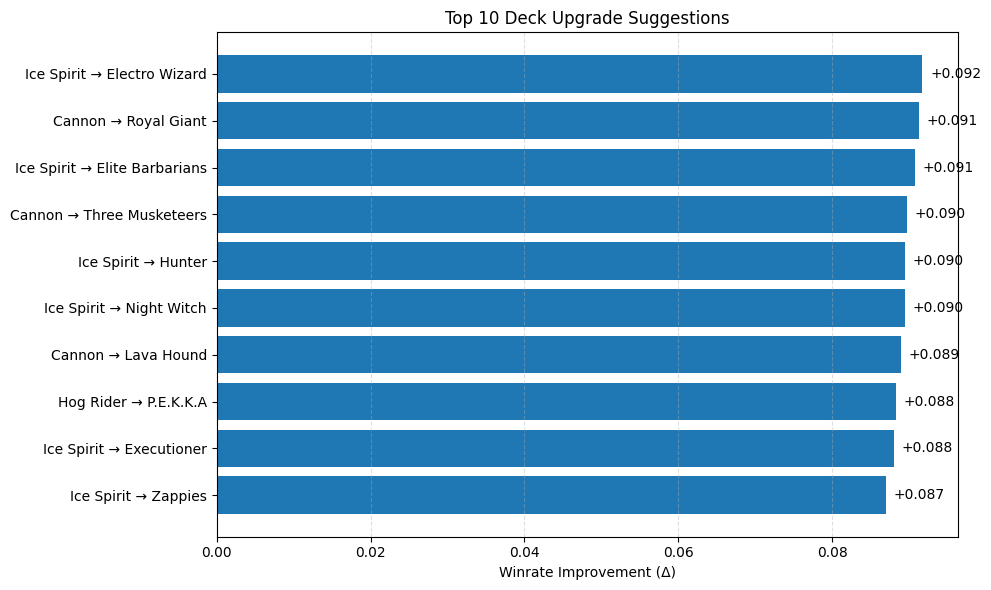

In [ ]:
import matplotlib.pyplot as plt
top10 = improvements[:10]

# Build labels like "Zap → Mega Knight"
labels = [f"{imp['old_name']} → {imp['new_name']}" for imp in top10]

# Winrate deltas
deltas = [imp['delta'] for imp in top10]

plt.figure(figsize=(10, 6))
bars = plt.barh(labels, deltas)

plt.xlabel("Winrate Improvement (Δ)")
plt.title("Top 10 Deck Upgrade Suggestions")

plt.gca().invert_yaxis()  # biggest improvement at the top
plt.grid(axis='x', linestyle='--', alpha=0.4)

# Add text values next to bars
for bar, val in zip(bars, deltas):
    plt.text(bar.get_width() + 0.001,
             bar.get_y() + bar.get_height()/2,
             f"+{val:.3f}", va='center')

plt.tight_layout()
plt.show()
